# Food Image Categorization Utilizing CNN
### Kaggle Link:
The link to the kaggle dataset can be found here: https://www.kaggle.com/datasets/kmader/food41/data 

### Overview:
The primary goal of this project is to build a deep learning model capable of classifying images into one of the 101 food categories using the Food-101 dataset. The project explores various neural network architectures, starting with custom Convolutional Neural Networks (CNNs) and progressing to advanced pre-trained models, to evaluate their effectiveness in tackling a complex multi-class classification problem.

The Food-101 dataset is a popular benchmark dataset for image classification tasks. It contains 101 categories of food, each with 1,000 images. The key features of the dataset are: 

- Number of Classes: 101 food categories (e.g., pizza, burgers, salads, desserts).
- Total Images: 101,000 images.
- Image Resolution: Varies, but resized for this project (e.g., 128x128 or 256x256).
- Class Distribution: Each class has exactly 1,000 images, ensuring balanced representation.



### Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import zipfile
import random
from tensorflow.keras.utils import load_img, img_to_array


from tensorflow.keras.applications import MobileNetV2

### Import Data from Kaggle

In [2]:
# Path to the dataset folder
data_dir = "/kaggle/input/food41/images"

### Exploratory Data Analysis (EDA):
Since the data is described in the Kaggle link, there is not much cleaning that needs to be addressed. The EDA process is as simple as investigating the categories further and by examining a few of the sample images. A distribution plot was not provided as every image category has 1,000 images. 

In [3]:
# List all categories
categories = os.listdir(data_dir)
print(f"Total categories: {len(categories)}")
print(f"Sample categories: {categories[:5]}")

# Count images per category
image_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}
print("Number of images per category:")
for category, count in list(image_counts.items())[:5]:  # Display the first 5 categories
    print(f"{category}: {count}")

Total categories: 101
Sample categories: ['macarons', 'french_toast', 'lobster_bisque', 'prime_rib', 'pork_chop']
Number of images per category:
macarons: 1000
french_toast: 1000
lobster_bisque: 1000
prime_rib: 1000
pork_chop: 1000


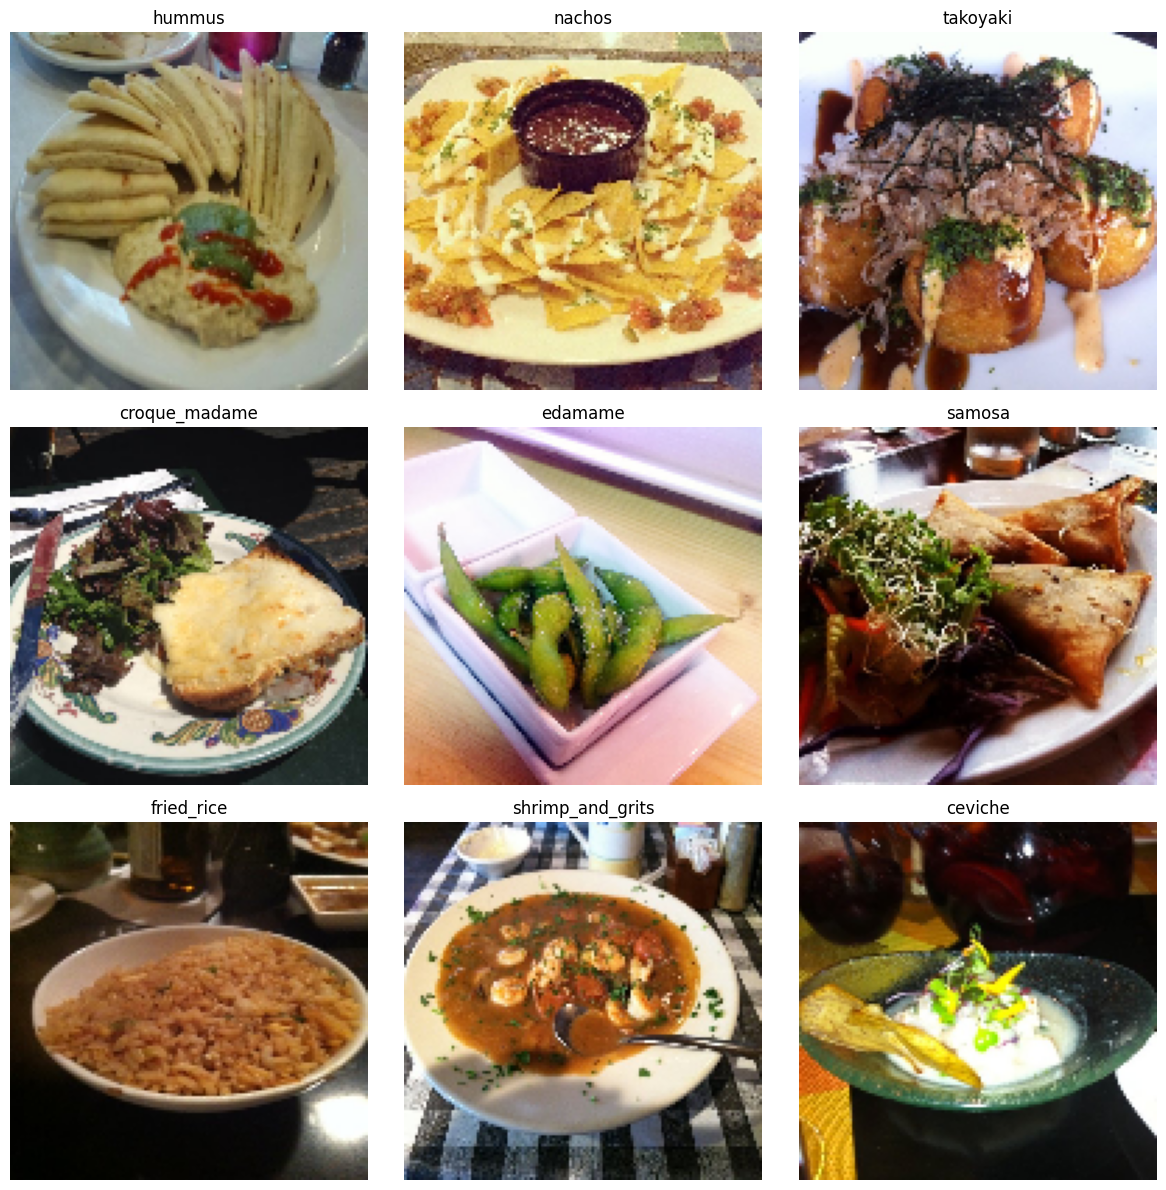

In [4]:
# Display 9 random images from different categories
plt.figure(figsize=(12, 12))
for i, category in enumerate(random.sample(categories, 9)):
    # Select a random image from the category folder
    image_path = os.path.join(data_dir, category, random.choice(os.listdir(os.path.join(data_dir, category))))
    img = load_img(image_path, target_size=(128, 128))  # Resize for visualization

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Baseline Model: 
This is a simple model intended to gain a understanding of how to adjust and tune. 

The architecture for the baseline model is detailed below:

1. **Input Layer:** Takes images of shape 128 x 128 pixels with 3 color channels (RGB)
2. **Convolutional Layers:**
      *  **First Convolutional Layer:** 32 filters with kernel size (3,3). ReLU Activation.
      *  **Max Pooling Layer:** Reduce spatial dimensions by a factor of 2.
      *  **Second Convolutional Layer:** 64 filters with a kernel size of (3,3) Relu Activation.
      *  **Max Pooling Layer:** Reduce spatial dimensions by a factor of 2.
      *  **Third Convolutional Layer:** 128 filters with a kernel size of (3,3) Relu Activation.
      *  **Max Pooling Layer:** Reduce spatial dimensions by a factor of 2.
3. **Flatten Layer:** Converts the two dimensional feature maps from the last convolutional layer into a single dimension vector.
4. **Dense Layers:**
      * **First Dense Layer:** Fully connected; 128 neurons and ReLU activation.
      * **Output Layer:** Single neuron with a sigmoid activation.
5. **Optimizer:** Utilizes an Adam Optimizer with a Loss Function of Sparse Categorical Crossentropy.

In [5]:
# Load training and validation datasets
batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot

In [6]:
# Create the Baseline Model
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),  # Match the input image size
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(len(class_names), activation="softmax")  # Multi-class output layer
])

# Optimize the model and gather accuracy metrics
baseline_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print the Baseline Model summary
baseline_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,317,669 (12.66 MB)

 Trainable params: 3,317,669 (12.66 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Shuffle and take a smaller subset of the training dataset
subset_train_ds = train_ds.take(500)  # Take only 500 batches
subset_val_ds = val_ds.take(100)  # Take only 100 batches

In [8]:
epochs = 10

history = baseline_model.fit(
    subset_train_ds,
    validation_data=subset_val_ds,
    epochs=epochs
)

Epoch 1/10


I0000 00:00:1733807256.851569      76 service.cc:145] XLA service 0x7be3b0005080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733807256.851634      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733807256.851639      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 13/500 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.0123 - loss: 4.8161

I0000 00:00:1733807260.617409      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.0122 - loss: 4.6177 - val_accuracy: 0.0441 - val_loss: 4.4236
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.0527 - loss: 4.3542 - val_accuracy: 0.0669 - val_loss: 4.2261
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.0862 - loss: 4.0815 - val_accuracy: 0.0809 - val_loss: 4.1298
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.1220 - loss: 3.8274 - val_accuracy: 0.0884 - val_loss: 4.1708
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.1833 - loss: 3.4444 - val_accuracy: 0.0831 - val_loss: 4.5017
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.2834 - loss: 2.9460 - val_accuracy: 0.0819 - val_loss: 4.9583
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.3982 - loss: 2.3882 - val_accuracy: 0.0756 - val_loss: 5.4990
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.5265 - loss: 1.8085 - val_accurac

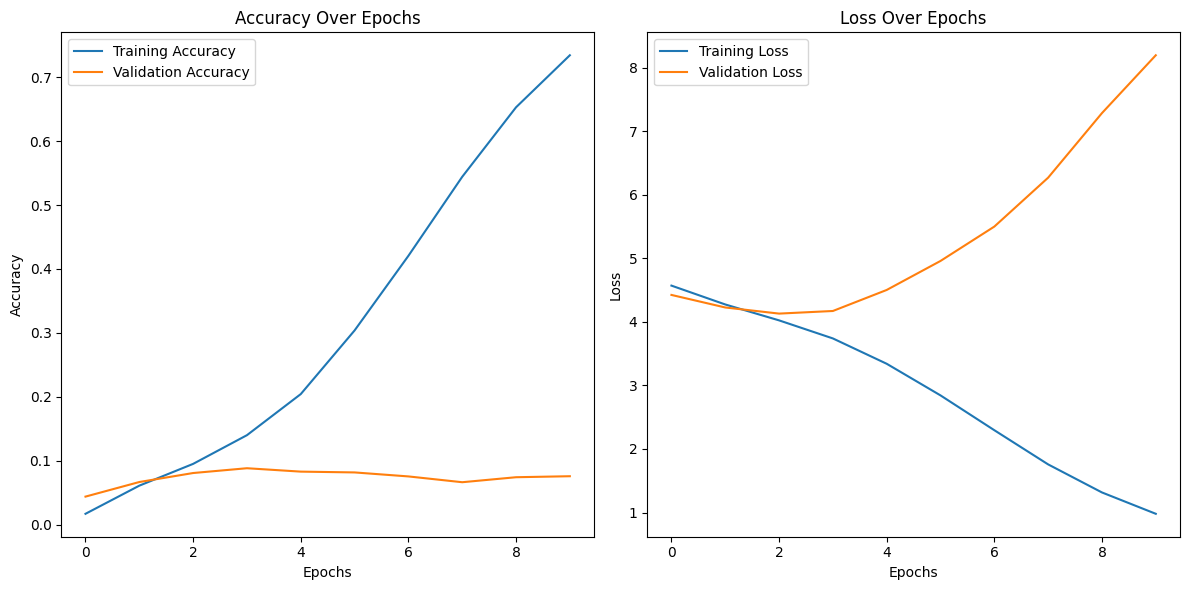

In [9]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Model 2
The following adjustments were made to the baseline model:

1. **Input Shape:**
    - The shape of the input was previously (128, 128, 3), whereas it was increased to (256, 256, 3)
    - Reasoning: To captures more detailed spatial features and hopefully yield better accuracy. 
2. **Dense Layer Neurons:**
    - Was adjusted (from 128 to 256) to reflect the input shape.
    - Reasoning: Help capture additional details in spatial features.
3. **Dropout:**
    - A dropout factor of 0.5 was added after previously not having one in the baseline model.
    - Reasoning: To reduce overfitting by adding regularization.
4. **Learning Rate:**
    - Adjusted from the default Adam learning rate to 1e-4.
    - Reasoning: Help with the optimization and convergence overall

In [10]:
# Load training and validation datasets

batch_size2 = 32
img_height2 = 256
img_width2 = 256

train_ds2 = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height2, img_width2),
    batch_size=batch_size2
)

val_ds2 = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height2, img_width2),
    batch_size=batch_size2
)

# Print class names
class_names = train_ds2.class_names
print(f"Class names: {class_names}")

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot

In [11]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="relu"),  # Increase Dense layer neurons
    Dropout(0.5),  # Add Dropout to prevent overfitting
    Dense(len(class_names), activation="softmax")
])

# Optimize the model and gather accuracy metrics
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-4)
model2.compile(optimizer=optimizer2, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print the Baseline Model summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,610,661 (112.96 MB)

 Trainable params: 29,610,661 (112.96 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y))
val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y))

# Shuffle and take a smaller subset of the training dataset
subset_train_ds2 = train_ds2.take(500)  # Take only 500 batches
subset_val_ds2 = val_ds2.take(100)  # Take only 100 batches

In [13]:
epochs = 10
history2 = model2.fit(
    subset_train_ds2,
    validation_data=subset_val_ds2,
    epochs=epochs
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.0121 - loss: 4.6335 - val_accuracy: 0.0284 - val_loss: 4.5553
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.0256 - loss: 4.5500 - val_accuracy: 0.0372 - val_loss: 4.4741
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.0385 - loss: 4.4575 - val_accuracy: 0.0556 - val_loss: 4.3695
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.0546 - loss: 4.3207 - val_accuracy: 0.0694 - val_loss: 4.2858
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.0746 - loss: 4.1747 - val_accuracy: 0.0725 - val_loss: 4.2374
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.1036 - loss: 3.9577 - val_accuracy: 0.0691 - val_loss: 4.2305
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.1327 - loss: 3.7465 - val_accuracy: 0.0741 - val_loss: 4.2448
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.1778 - loss: 3.4866 - 

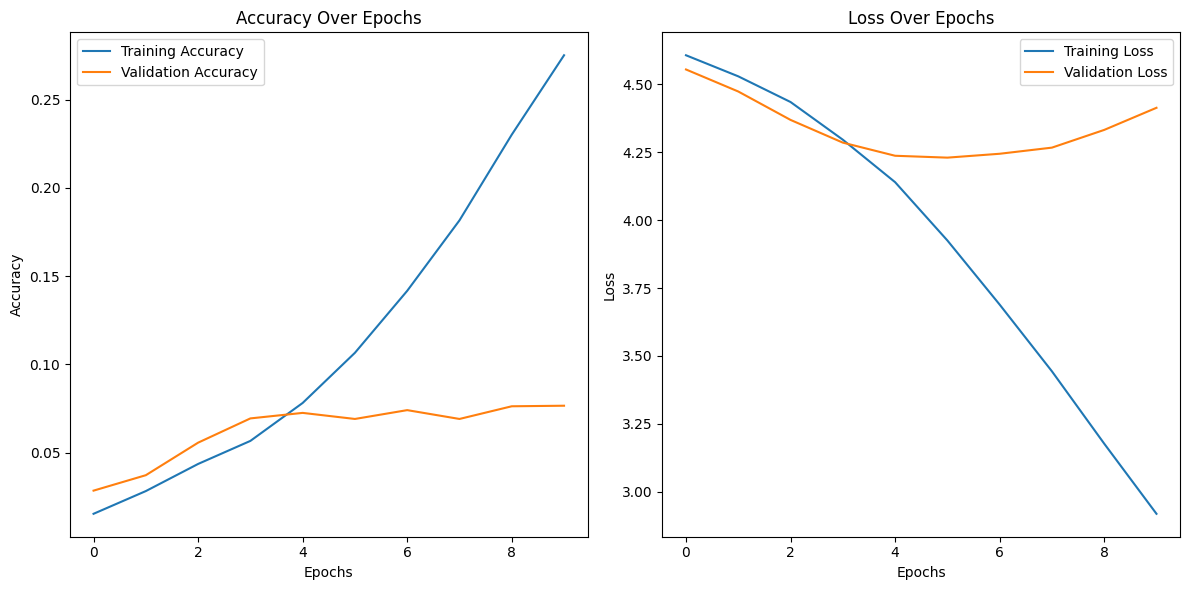

In [14]:
# Extract accuracy and loss from the history object
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Create a figure
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy2, label='Training Accuracy')
plt.plot(val_accuracy2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Model 3

1. **Batch Normalization**
    - Was added after every Conv2D layer and the Dense Layer.
    - Reasoning: Stabilizes training and speeds up convergence.
2. **Dropout:**
    - The dropout factor of 0.5 from Model 2 was reduced to 0.4. 
    - Reasoning: A slightly lower dropout rate strikes a balance between regularization and model capacity. This adjustment helps retain more neurons while still preventing overfitting.


In [15]:
# Load training and validation datasets
batch_size3 = 32
img_height3 = 256
img_width3 = 256

train_ds3 = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height3, img_width3),
    batch_size=batch_size3
)

val_ds3 = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height3, img_width3),
    batch_size=batch_size3
)

# Print class names
class_names = train_ds3.class_names
print(f"Class names: {class_names}")

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot

In [16]:
from tensorflow.keras.layers import BatchNormalization

model3 = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(len(class_names), activation="softmax")  # Output layer for classification
])

# Compile the model with the same optimizer and learning rate
optimizer3 = tf.keras.optimizers.Adam(learning_rate=1e-4)
model3.compile(optimizer=optimizer3, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,612,581 (112.96 MB)

 Trainable params: 29,611,621 (112.96 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
train_ds3 = train_ds3.map(lambda x, y: (normalization_layer(x), y))
val_ds3 = val_ds3.map(lambda x, y: (normalization_layer(x), y))

# Shuffle and take a smaller subset of the training dataset
subset_train_ds3 = train_ds3.take(500)  # Take only 500 batches
subset_val_ds3 = val_ds3.take(100)  # Take only 100 batches

In [18]:
epochs = 10
history3 = model3.fit(
    subset_train_ds3,
    validation_data=subset_val_ds3,
    epochs=epochs
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 77ms/step - accuracy: 0.0351 - loss: 5.0599 - val_accuracy: 0.0519 - val_loss: 4.5826
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.1430 - loss: 3.8490 - val_accuracy: 0.0959 - val_loss: 4.3131
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.4640 - loss: 2.4134 - val_accuracy: 0.0959 - val_loss: 4.3762
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.8583 - loss: 0.9245 - val_accuracy: 0.0931 - val_loss: 4.3534
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9817 - loss: 0.2730 - val_accuracy: 0.0791 - val_loss: 4.6606
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9957 - loss: 0.1362 - val_accuracy: 0.0841 - val_loss: 4.5177
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9998 - loss: 0.0516 - val_accuracy: 0.0947 - val_loss: 4.4500
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9999 - loss: 0.0297 - 

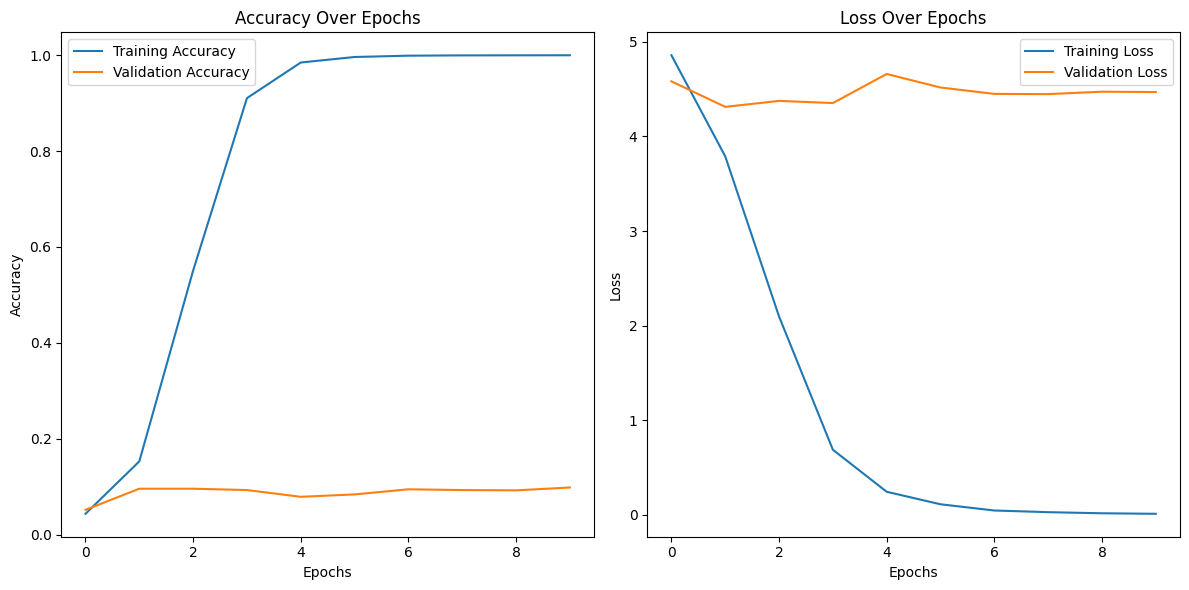

In [19]:
# Extract accuracy and loss from the history object
accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

# Create a figure
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy3, label='Training Accuracy')
plt.plot(val_accuracy3, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### This is the MobileNetV2 Model (Transfer Learning)
The final model utilizes transfer learning via the MobileNetV2 model. The architecture for the MobileNetV2 Model was not adjusted in this project. From https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/ the architecture for the MobileNetV2 Model is:


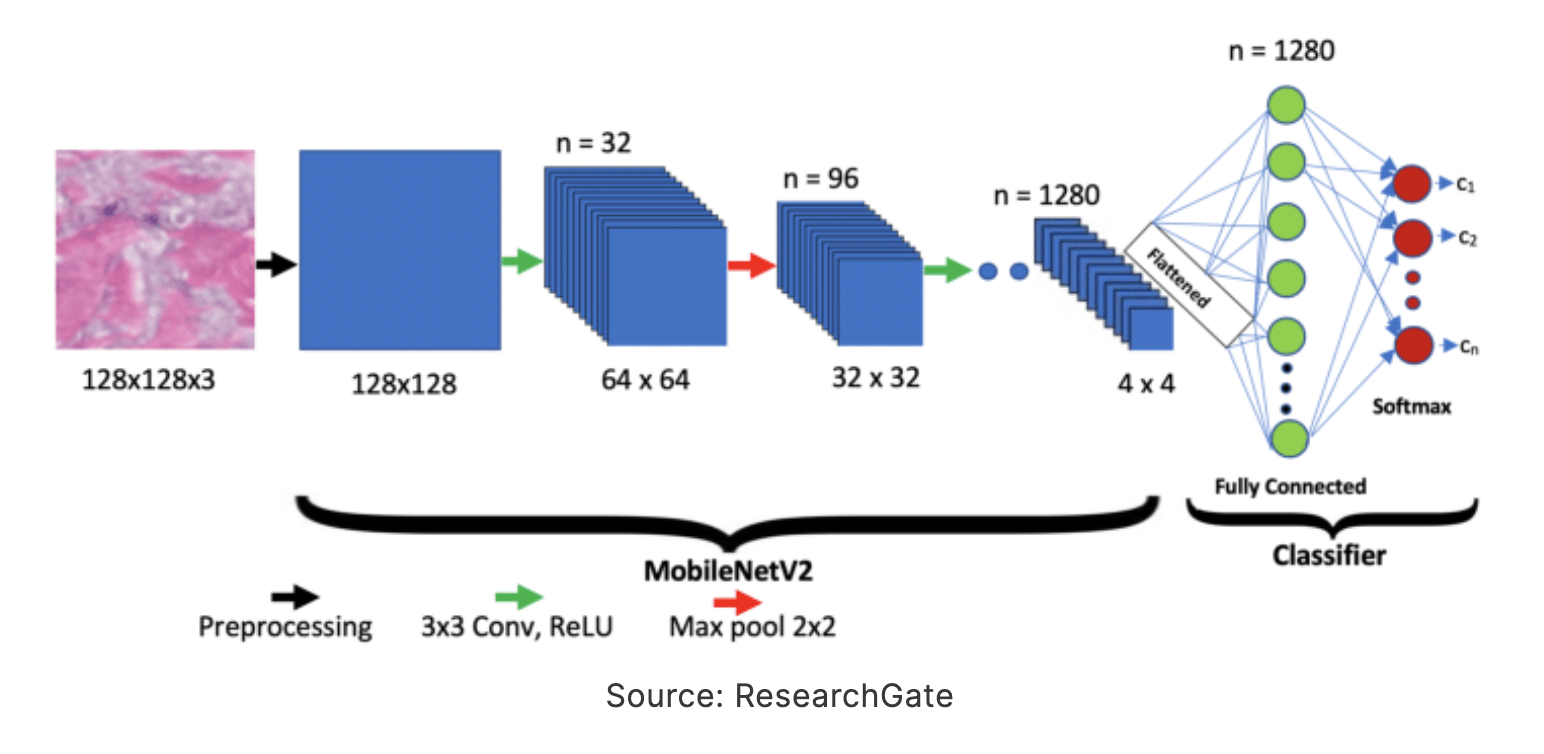

In [20]:
batch_size_mnv2 = 32
img_height_mnv2 = 224
img_width_mnv2 = 224

train_ds_mnv2 = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height_mnv2, img_width_mnv2),
    batch_size=batch_size_mnv2
)

val_ds_mnv2 = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height_mnv2, img_width_mnv2),
    batch_size=batch_size_mnv2
)

# Print class names
class_names = train_ds_mnv2.class_names
print(f"Class names: {class_names}")

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot

In [21]:
train_ds_mnv2 = train_ds_mnv2.map(lambda x, y: (normalization_layer(x), y))
val_ds_mnv2 = val_ds_mnv2.map(lambda x, y: (normalization_layer(x), y))

# Shuffle and take a smaller subset of the training dataset
subset_train_ds_mnv2 = train_ds_mnv2.take(500)  # Take only 500 batches
subset_val_ds_mnv2 = val_ds_mnv2.take(100)  # Take only 100 batches

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load the base model
base_model = MobileNetV2(input_shape=(img_height_mnv2, img_width_mnv2, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze the base model


# Add custom layers
mnv2_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # Number of categories
])

# Compile the model
mnv2_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
mnv2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
epochs = 10
history_mnv2 = mnv2_model.fit(
    subset_train_ds_mnv2,
    validation_data=subset_val_ds_mnv2,
    epochs=epochs
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.2106 - loss: 3.5726 - val_accuracy: 0.4647 - val_loss: 2.2018
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5194 - loss: 1.8717 - val_accuracy: 0.5003 - val_loss: 2.0377
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5976 - loss: 1.5496 - val_accuracy: 0.5044 - val_loss: 2.0191
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6404 - loss: 1.3737 - val_accuracy: 0.5191 - val_loss: 1.9974
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6654 - loss: 1.2411 - val_accuracy: 0.5066 - val_loss: 2.0417
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6892 - loss: 1.1446 - val_accuracy: 0.5150 - val_loss: 2.0288
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7211 - loss: 1.0440 - val_accuracy: 0.5091 - val_loss: 2.0619
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7320 - loss: 0.9831 - 

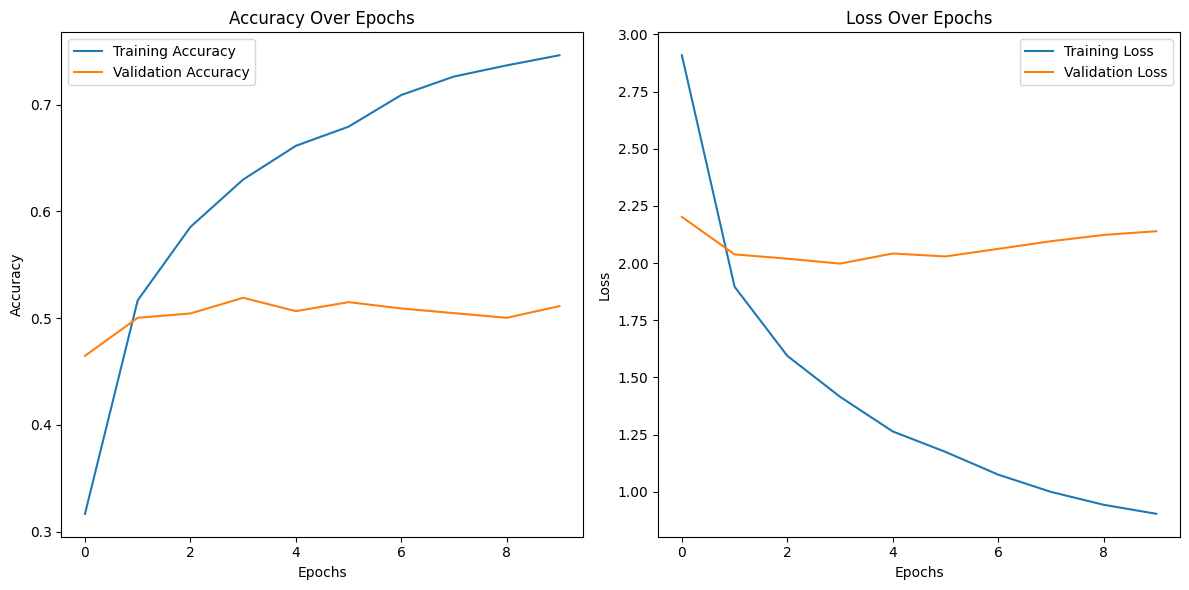

In [24]:
# Extract accuracy and loss from the history object
accuracy_mnv2 = history_mnv2.history['accuracy']
val_accuracy_mnv2 = history_mnv2.history['val_accuracy']
loss_mnv2 = history_mnv2.history['loss']
val_loss_mnv2 = history_mnv2.history['val_loss']

# Create a figure
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy_mnv2, label='Training Accuracy')
plt.plot(val_accuracy_mnv2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss_mnv2, label='Training Loss')
plt.plot(val_loss_mnv2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [25]:
# Evaluate each model
baseline_eval = baseline_model.evaluate(val_ds, verbose=0)
model2_eval = model2.evaluate(val_ds2, verbose=0)
model3_eval = model3.evaluate(val_ds3, verbose=0)
mnv2_eval = mnv2_model.evaluate(val_ds_mnv2, verbose=0)

# Store results in a dictionary
results = {
    "Model": ["Baseline Model", "Model 2 (Improved CNN)", "Model 3 (BatchNorm)", "MobileNetV2"],
    "Validation Loss": [baseline_eval[0], model2_eval[0], model3_eval[0], mnv2_eval[0]],
    "Validation Accuracy": [baseline_eval[1], model2_eval[1], model3_eval[1], mnv2_eval[1]]
}
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

                    Model  Validation Loss  Validation Accuracy
0          Baseline Model         8.318852             0.067426
1  Model 2 (Improved CNN)         4.417621             0.070941
2     Model 3 (BatchNorm)         4.518052             0.085198
3             MobileNetV2         2.183666             0.494505


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


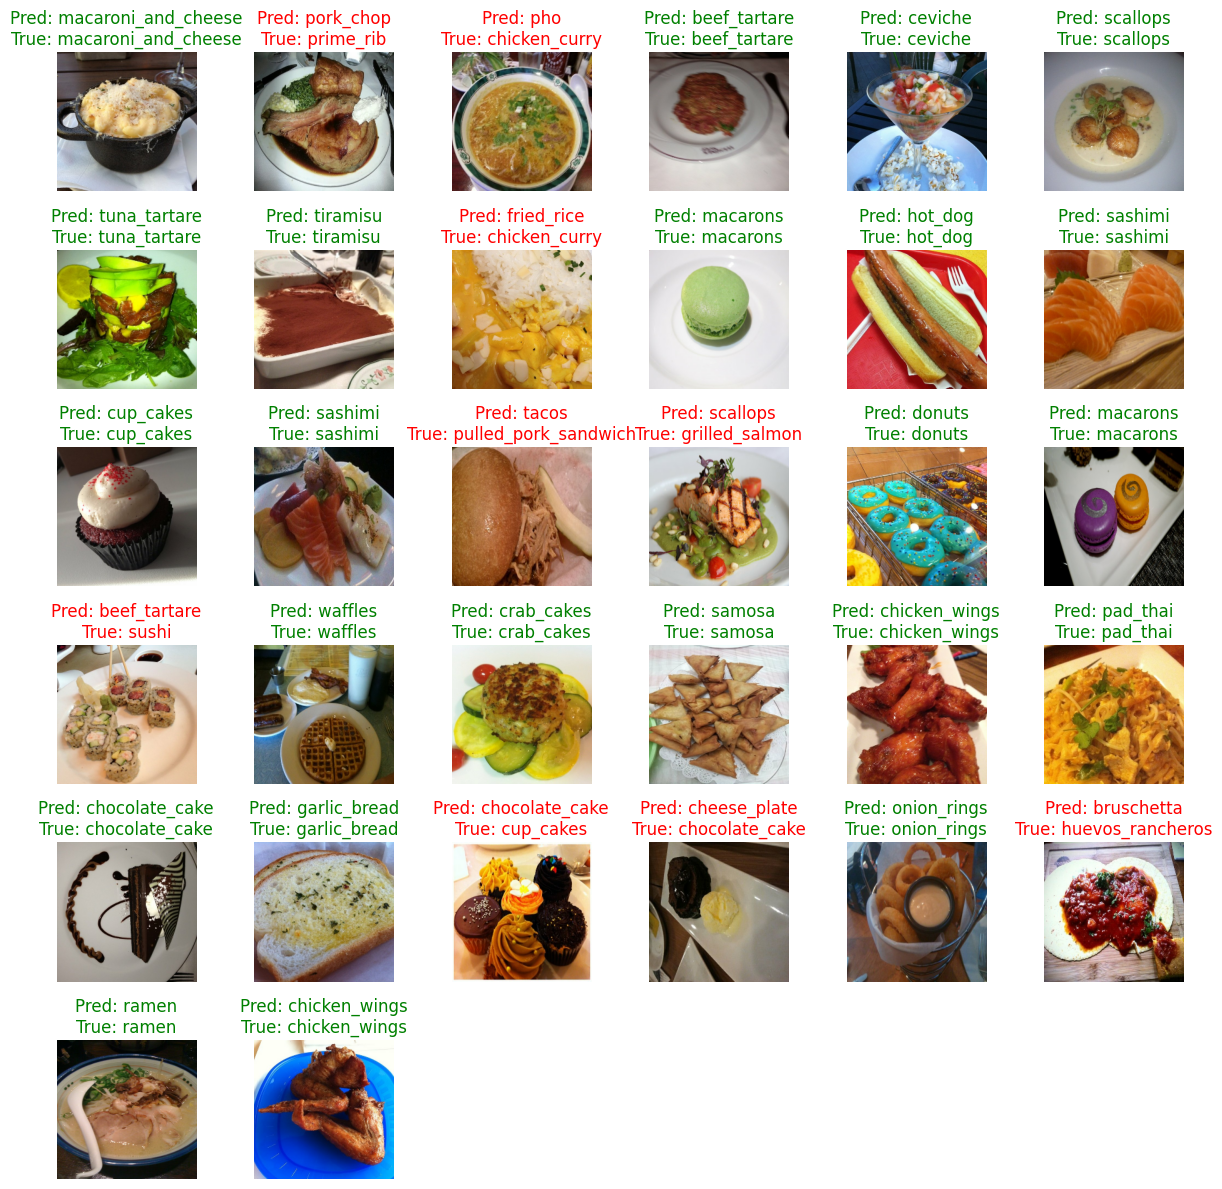

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images from the validation dataset
for images, labels in val_ds_mnv2.take(1):  # Take one batch of images
    # If images are normalized, rescale them back to [0, 255]
    rescaled_images = images.numpy() * 255  # Scale normalized images to the proper range
    rescaled_images = rescaled_images.astype("uint8")  # Convert to uint8 for proper display

    # Get model predictions
    predictions = mnv2_model.predict(images)  
    predicted_labels = np.argmax(predictions, axis=1)

    # Map numerical labels to class names
    predicted_class_names = [class_names[i] for i in predicted_labels]
    true_class_names = [class_names[i] for i in labels.numpy()]

    # Plot the images with predicted and true labels
    num_images = len(rescaled_images)
    grid_size = int(np.ceil(np.sqrt(num_images)))  # Dynamic grid size based on the batch size

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(rescaled_images[i])  # Display the rescaled image
        color = "green" if predicted_labels[i] == labels.numpy()[i] else "red"
        plt.title(f"Pred: {predicted_class_names[i]}\nTrue: {true_class_names[i]}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()



### Conclusions:
1. Baseline Model:
    - Validation Loss: 6.729179
    - Validation Accuracy: 0.075347

The baseline model fails to learn meaningful patterns, which is indicated by the very high validation loss value and low validation accuracy. Based on the plots developed, the training  accuracy shows that there is some steady improvement, but with minimal increase to the validation accuracy. This indicates that there is potentital overfitting or model capabilities to handle the dataset complexity. 


2. Model 2 (Improved CNN):
    - Validation Loss: 4.465222
    - Validation Accuracy: 0.071733

Model 2 improves over the baseline by adding a larger input size, increasing the number of neurons in the dense layer, adding a dropout and by adjusting the learning rate. Despite the adjustments, the validation accuracy is still similiar to that of the baseline model. 
Despite these changes, validation accuracy remains comparable to the baseline, and loss is still quite high.

3. Model 3 (Batch Normalization):
    - Validation Loss: 4.517851
    - Validation Accuracy: 0.084109

Model 3 introduces Batch Normalization to stabilize training and reduce overfitting.
The validation accuracy is slightly better than the previous models, and the loss is similar to Model 2.Batch Normalization likely improved convergence, but the model still struggles to generalize effectively to the validation set.

4. MobileNetV2:
    - Validation Loss: 2.150652
    - Validation Accuracy: 0.500248

The MobileNetV2 model significantly outperforms the other models in both loss reduction and validation accuracy. The use of a pre-trained model allows MobileNetV2 to leverage robust feature extraction, drastically improving performance. The validation accuracy suggests the model is learning meaningful patterns and generalizing better than the other models.

Future work should focus on:
Fine-tuning MobileNetV2 layers.
Experimenting with other pre-trained architectures (e.g., EfficientNet, InceptionV3).
Using data augmentation to improve model generalization further.

### Citations:
Citation: Sharma, N. (2024, November 26). What is MobileNetV2? Features, Architecture, Application and More. Analytics Vidhya. Retrieved from https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/